In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
! pip install folium==0.5.0
import folium

# Step 1: Load the neighborhood coordinates database.

In [2]:
csv_path = 'limite-des-quartiers-de-lille-et-de-ses-communes-associees.csv'
df_Lille = pd.read_csv(csv_path, delimiter='\;')
Lille_data = df_Lille.drop(['Code_com', 'Code_quar', 'Geo Shape'], axis=1)
Lille_data = Lille_data.rename(columns={"Quartier": "Neighborhood", "Code_post": "Postal Code", "Geo Point":"Coordinates"})

csv_path = 'VilleMTP_MTP_SousQuartiers-1.csv'
df_MTP = pd.read_csv(csv_path, delimiter='\t')
MTP_data = df_MTP.drop(['AREA', 'OBJECTID', 'PERIMETER', 'SQUARTIER_', 'QUARTIER', 'SQUARTMNO', 'Shape_Leng', 'Shape_Area'], axis=1)
MTP_data = MTP_data.rename(columns={"LIBSQUART": "Neighborhood"})

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
lat = []
lon = []
for row in Lille_data['Coordinates']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
        
    except:
        lat.append(np.NaN)
        lon.append(np.Nan)
Lille_data['Latitude']=lat
Lille_data['Longitude']=lon
Lille_data = Lille_data.drop(['Coordinates'], axis=1)
Lille_data['Latitude'] = Lille_data['Latitude'].astype(float)
Lille_data['Longitude'] = Lille_data['Longitude'].astype(float)

Data was cleaned, split Coordinates into Latitude and Longitude then converted them from object to float type so they can be read in folium map.

In [4]:
print(Lille_data.dtypes)

Commune          object
Neighborhood     object
Postal Code       int64
Latitude        float64
Longitude       float64
dtype: object


Four neighborhoods were dropped because 

# Set up Foursquare Information

In [5]:
CLIENT_ID = 'LKUGLYOQPM0IAHR5PSONM3M520JMWGB4QGXF3AXZXWUB1YSK'
CLIENT_SECRET = 'CSJEOQYAROD2CNE4RGP4S4K1Z40JTWG4RO5BTWIRYE5IP3YV'
ACCESS_TOKEN = 'MYZALMYCUEP3YI5NWDL3MXAIXMOOUCLCVRAYXMRMVT0WQSLI'
VERSION = '20180604'
LIMIT = 100

In [6]:
address = 'Lille, Lille'
geolocator = Nominatim(user_agent="Lille_explorer")
location_Lille = geolocator.geocode(address)
latitude_Lille = location_Lille.latitude
longitude_Lille = location_Lille.longitude
print('The Coordinates of Lille are {}, {}.'.format(latitude_Lille, longitude_Lille))

The Coordinates of Lille are 50.6365654, 3.0635282.


In [7]:
address = 'Montpellier, Montpellier'
geolocator = Nominatim(user_agent="MTP_explorer")
location_MTP = geolocator.geocode(address)
latitude_MTP = location_MTP.latitude
longitude_MTP = location_MTP.longitude
print('The Coordinates of Montpellier are {}, {}.'.format(latitude_MTP, longitude_MTP))

The Coordinates of Montpellier are 43.6112422, 3.8767337.


In [8]:
print('The Lille dataframe has {} Postal Codes and {} neighborhoods.'.format(
        len(Lille_data['Postal Code'].unique()),
        Lille_data.shape[0]
    )
)
print('The Montpellier dataframe has {} Postal Codes and {} neighborhoods.'.format(
        len(MTP_data['Postal Code'].unique()),
        MTP_data.shape[0]
    )
)

The Lille dataframe has 3 Postal Codes and 12 neighborhoods.
The Montpellier dataframe has 4 Postal Codes and 31 neighborhoods.


# Neighborhood Maps of Montpellier and Lille

In [9]:
# create map of New York using latitude and longitude values
map_Montpellier = folium.Map(location=[latitude_MTP, longitude_MTP], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(MTP_data['Latitude'], MTP_data['Longitude'], MTP_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Montpellier)  
    
map_Montpellier

In [10]:
map_Lille = folium.Map(location=[latitude_Lille, longitude_Lille], zoom_start=12)

for lat, lng, neighborhood in zip(Lille_data['Latitude'], Lille_data['Longitude'], Lille_data['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Lille)  
    
map_Lille

# Step 3: Foursquare Venue Information

In [11]:
CLIENT_ID = 'LKUGLYOQPM0IAHR5PSONM3M520JMWGB4QGXF3AXZXWUB1YSK' # your Foursquare ID
CLIENT_SECRET = 'CSJEOQYAROD2CNE4RGP4S4K1Z40JTWG4RO5BTWIRYE5IP3YV' # your Foursquare Secret
ACCESS_TOKEN = 'MYZALMYCUEP3YI5NWDL3MXAIXMOOUCLCVRAYXMRMVT0WQSLI' # your FourSquare Access Token
VERSION = '20180605'
LIMIT = 100
radius=1000
categoryId= '4d4b7105d754a06374d81259'

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat_Lille, lng_Lille in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat_Lille, 
            lng_Lille,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat_MTP, lng_MTP in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat_MTP, 
            lng_MTP,
            categoryId,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat_MTP, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
Lille_venues = getNearbyVenues(names=Lille_data['Neighborhood'],
                                   latitudes=Lille_data['Latitude'],
                                   longitudes=Lille_data['Longitude']
                                  )
Montpellier_venues = getNearbyVenues(names=MTP_data['Neighborhood'],
                                   latitudes=MTP_data['Latitude'],
                                   longitudes=MTP_data['Longitude']
                                  )

Lille-Moulins
Faubourg de Béthune
Lomme
Bois-Blancs
Hellemmes
Vauban-Esquermes
Saint-Maurice Pellevoisin
Lille-Centre
Wazemmes
Lille-Sud
Vieux-Lille
Fives
Plan des 4 Seigneurs
Hopitaux-Facultés
Aiguelongue
Les Hauts de Massane
Alco
Mosson
Grammont
Les Aubes
Boutonnet
Les Beaux - Arts
La Pompignane
Millénaire
Les Cevennes
Celleneuve
Les Arceaux
Centre Historique
Antigone
Comédie
La Martelle
Port Marianne
La Chamberte
Gambetta
Figuerolles
Gares
Estanove
Aiguerelles
Saint Martin
Lemasson
Pas du Loup
Croix d'Argent
Près d'Arènes


In [15]:
Lille_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Lille-Moulins,50.619097,3.089985,La Consigne,50.625019,3.069697,Restaurant
1,Lille-Moulins,50.619097,3.089985,Layalina,50.624922,3.060513,Mediterranean Restaurant
2,Lille-Moulins,50.619097,3.089985,Baan Boon,50.624856,3.068454,Thai Restaurant
3,Lille-Moulins,50.619097,3.089985,Baba Yaga,50.626352,3.064073,Russian Restaurant
4,Lille-Moulins,50.619097,3.089985,Friterie Sensas,50.624517,3.068810,Friterie


In [16]:
Montpellier_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Plan des 4 Seigneurs,43.6375,3.089985,Boulangerie du Plan,43.640580,3.857756,Bakery
1,Plan des 4 Seigneurs,43.6375,3.089985,Trinque Fougasse,43.640354,3.862381,French Restaurant
2,Plan des 4 Seigneurs,43.6375,3.089985,"Picadeli, bar à salades",43.629636,3.851393,Salad Place
3,Plan des 4 Seigneurs,43.6375,3.089985,Resto U Triolet,43.630990,3.859983,Restaurant
4,Hopitaux-Facultés,43.6329,3.089985,"Picadeli, bar à salades",43.629636,3.851393,Salad Place


In [17]:
Montpellier_venues.groupby('Neighborhood').count()
Lille_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bois-Blancs,30,30,30,30,30,30
Faubourg de Béthune,7,7,7,7,7,7
Fives,10,10,10,10,10,10
Hellemmes,8,8,8,8,8,8
Lille-Centre,100,100,100,100,100,100
Lille-Moulins,22,22,22,22,22,22
Lille-Sud,6,6,6,6,6,6
Lomme,4,4,4,4,4,4
Saint-Maurice Pellevoisin,19,19,19,19,19,19


In [18]:
print('There are {} uniques categories for Lille.'.format(len(Lille_venues['Venue Category'].unique())))
print('There are {} uniques categories for Montpellier.'.format(len(Montpellier_venues['Venue Category'].unique())))

There are 48 uniques categories for Lille.
There are 39 uniques categories for Montpellier.


One hot encoding for the venues of Lille and Montpellier

In [19]:
# one hot encoding
Montpellier_onehot = pd.get_dummies(Montpellier_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Montpellier_onehot['Neighborhood'] = Montpellier_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Montpellier_onehot.columns[-1]] + list(Montpellier_onehot.columns[:-1])
Montpellier_onehot = Montpellier_onehot[fixed_columns]

# one hot encoding
Lille_onehot = pd.get_dummies(Lille_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Lille_onehot['Neighborhood'] = Lille_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Lille_onehot.columns[-1]] + list(Lille_onehot.columns[:-1])
Lille_onehot = Lille_onehot[fixed_columns]

Lille_onehot.head()

,Neighborhood,African Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Breakfast Spot,Burger Joint,Burrito Place,Cafeteria,Café,Ch'ti Restaurant,Chinese Restaurant,Comfort Food Restaurant,Creperie,Deli / Bodega,Diner,Estaminet,Falafel Restaurant,Fast Food Restaurant,Food Truck,French Restaurant,Friterie,Gastropub,Greek Restaurant,Halal Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Pet Café,Pizza Place,Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Seafood Restaurant,Snack Place,Steakhouse,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vietnamese Restaurant
0,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Lille-Moulins,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
Montpellier_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Burger Joint,Cafeteria,Café,Creperie,Diner,Eastern European Restaurant,Empanada Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Moroccan Restaurant,Pizza Place,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant
0,Plan des 4 Seigneurs,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Plan des 4 Seigneurs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Plan des 4 Seigneurs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,Plan des 4 Seigneurs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,Hopitaux-Facultés,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [21]:
Lille_onehot.shape

Montpellier_onehot.shape

(633, 40)

In [22]:
Lille_grouped = Lille_onehot.groupby('Neighborhood').mean().reset_index()
Lille_grouped.head(10)
Montpellier_grouped = Montpellier_onehot.groupby('Neighborhood').mean().reset_index()

In [23]:
Montpellier_grouped.head(10)

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Burger Joint,Cafeteria,Café,Creperie,Diner,Eastern European Restaurant,Empanada Restaurant,Fast Food Restaurant,Fish & Chips Shop,Food,Food Court,Food Truck,French Restaurant,Gastropub,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Mediterranean Restaurant,Moroccan Restaurant,Pizza Place,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Thai Restaurant
0,Aiguelongue,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.000000,0.333333,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,Aiguerelles,0.000000,0.00,0.000000,0.071429,0.071429,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.071429,0.000000,0.000000,0.214286,0.00,0.0,0.071429,0.0,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.071429,0.0,0.000000,0.000000
2,Alco,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,Antigone,0.014706,0.00,0.014706,0.000000,0.014706,0.044118,0.000000,0.058824,0.0,0.058824,0.058824,0.014706,0.000000,0.014706,0.014706,0.00,0.0,0.000000,0.0,0.235294,0.029412,0.014706,0.044118,0.014706,0.014706,0.014706,0.014706,0.014706,0.014706,0.058824,0.073529,0.014706,0.044118,0.014706,0.029412,0.000000,0.0,0.014706,0.029412
4,Boutonnet,0.000000,0.00,0.000000,0.000000,0.000000,0.153846,0.000000,0.000000,0.0,0.000000,0.000000,0.076923,0.000000,0.000000,0.153846,0.00,0.0,0.000000,0.0,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.384615,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,Celleneuve,0.000000,0.00,0.000000,0.166667,0.000000,0.500000,0.000000,0.166667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,Centre Historique,0.010000,0.01,0.010000,0.000000,0.030000,0.010000,0.020000,0.060000,0.0,0.110000,0.040000,0.030000,0.000000,0.010000,0.010000,0.01,0.0,0.000000,0.0,0.220000,0.030000,0.000000,0.030000,0.010000,0.000000,0.020000,0.010000,0.010000,0.010000,0.100000,0.080000,0.000000,0.040000,0.010000,0.010000,0.000000,0.0,0.030000,0.030000
7,Comédie,0.010000,0.01,0.010000,0.000000,0.030000,0.010000,0.020000,0.060000,0.0,0.110000,0.040000,0.030000,0.000000,0.010000,0.010000,0.01,0.0,0.000000,0.0,0.230000,0.030000,0.000000,0.030000,0.010000,0.000000,0.020000,0.010000,0.010000,0.010000,0.090000,0.080000,0.000000,0.040000,0.010000,0.010000,0.000000,0.0,0.030000,0.030000
8,Croix d'Argent,0.000000,0.00,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
9,Estanove,0.000000,0.00,0.000000,0.000000,0.000000,0.142857,0.142857,0.000000,0.0,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.285714,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [24]:
Lille_grouped.shape
Montpellier_grouped.shape

(31, 40)

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Lille_venues_sorted = pd.DataFrame(columns=columns)
Lille_venues_sorted['Neighborhood'] = Lille_grouped['Neighborhood']

for ind in np.arange(Lille_grouped.shape[0]):
    Lille_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Lille_grouped.iloc[ind, :], num_top_venues)
    
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Montpellier_venues_sorted = pd.DataFrame(columns=columns)
Montpellier_venues_sorted['Neighborhood'] = Montpellier_grouped['Neighborhood']

for ind in np.arange(Montpellier_grouped.shape[0]):
    Montpellier_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Montpellier_grouped.iloc[ind, :], num_top_venues)

Lille_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bois-Blancs,Sandwich Place,Restaurant,Pizza Place,Snack Place,Food Truck,Bakery,Italian Restaurant,Gastropub,Middle Eastern Restaurant,French Restaurant
1,Faubourg de Béthune,Italian Restaurant,Pizza Place,Modern European Restaurant,Fast Food Restaurant,Burger Joint,French Restaurant,Falafel Restaurant,Estaminet,Diner,Deli / Bodega
2,Fives,Pizza Place,French Restaurant,Sushi Restaurant,Bakery,Diner,Sandwich Place,Deli / Bodega,Italian Restaurant,Restaurant,Ch'ti Restaurant
3,Hellemmes,Kebab Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Comfort Food Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Falafel Restaurant
4,Lille-Centre,French Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Burger Joint,Café,Creperie,Fast Food Restaurant,Bakery,Sushi Restaurant
5,Lille-Moulins,Pizza Place,French Restaurant,Gastropub,Diner,Friterie,Thai Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Café
6,Lille-Sud,Pizza Place,Restaurant,Sandwich Place,French Restaurant,Café,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner,Deli / Bodega
7,Lomme,French Restaurant,Halal Restaurant,Bakery,Restaurant,Chinese Restaurant,Food Truck,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner
8,Saint-Maurice Pellevoisin,Pizza Place,Italian Restaurant,Restaurant,Gastropub,Salad Place,French Restaurant,Friterie,Japanese Restaurant,Fast Food Restaurant,Sandwich Place
9,Vauban-Esquermes,French Restaurant,Pizza Place,Café,Fast Food Restaurant,Snack Place,Bakery,Sandwich Place,Restaurant,Italian Restaurant,Chinese Restaurant


In [27]:
Montpellier_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aiguelongue,Fast Food Restaurant,Pizza Place,Restaurant,Café,Thai Restaurant,Cafeteria,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner
1,Aiguerelles,Fast Food Restaurant,Café,Sandwich Place,Mediterranean Restaurant,Bagel Shop,Diner,Japanese Restaurant,Food Court,BBQ Joint,Sushi Restaurant
2,Alco,Fast Food Restaurant,Salad Place,Restaurant,Pizza Place,Thai Restaurant,Cafeteria,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner
3,Antigone,French Restaurant,Restaurant,Burger Joint,Café,Creperie,Pizza Place,Italian Restaurant,Bakery,Sandwich Place,Gastropub
4,Boutonnet,Pizza Place,Fast Food Restaurant,Bakery,French Restaurant,Japanese Restaurant,Restaurant,Diner,Café,Fish & Chips Shop,Empanada Restaurant
5,Celleneuve,Bakery,BBQ Joint,Restaurant,Burger Joint,Thai Restaurant,Creperie,Food,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
6,Centre Historique,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Italian Restaurant,Bagel Shop,Diner
7,Comédie,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Italian Restaurant,Bagel Shop,Diner
8,Croix d'Argent,Fast Food Restaurant,Eastern European Restaurant,Bakery,Salad Place,Pizza Place,Thai Restaurant,Café,Fish & Chips Shop,Empanada Restaurant,Diner
9,Estanove,Pizza Place,Café,Bakery,Bistro,Restaurant,Mediterranean Restaurant,Thai Restaurant,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant


# Clustering of Neighborhoods

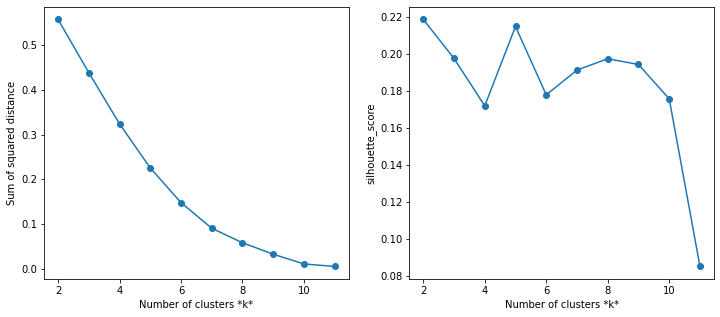

In [45]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sse = []
sscr =[]
list_k = list(range(2, 12))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0).fit(Lille_grouped_clustering)
    sse.append(km.inertia_)
    sscr.append(silhouette_score(Lille_grouped_clustering, km.labels_, metric='euclidean'))

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.subplot(122)
plt.plot(list_k, sscr, '-o',label='silhouette_score')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('silhouette_score');

In [ ]:
sse = []
sscr =[]
list_k = list(range(2, 30))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=0).fit(Montpellier_grouped_clustering)
    sse.append(km.inertia_)
    sscr.append(silhouette_score(Montpellier_grouped_clustering, km.labels_, metric='euclidean'))

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');
plt.subplot(122)
plt.plot(list_k, sscr, '-o',label='silhouette_score')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('silhouette_score');

In [28]:
# set number of clusters
kclusters = 5

Lille_grouped_clustering = Lille_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Lille_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 0, 0, 1, 0, 2, 4, 0, 0], dtype=int32)

In [29]:
# set number of clusters
kclusters = 5

Montpellier_grouped_clustering = Montpellier_grouped.drop('Neighborhood', 1)

# run k-means clustering
MTP_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Montpellier_grouped_clustering)

# check cluster labels generated for each row in the dataframe
MTP_kmeans.labels_[0:10] 

array([3, 1, 3, 0, 4, 2, 0, 0, 1, 3], dtype=int32)

In [30]:
# add clustering labels
Lille_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Lille_merged = Lille_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Lille_merged = Lille_merged.join(Lille_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Lille_merged.head() # check the last columns!

,Commune,Neighborhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lille,Lille-Moulins,59000,50.619097,3.070176,0,Pizza Place,French Restaurant,Gastropub,Diner,Friterie,Thai Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Café
1,Lille,Faubourg de Béthune,59000,50.618164,3.033288,3,Italian Restaurant,Pizza Place,Modern European Restaurant,Fast Food Restaurant,Burger Joint,French Restaurant,Falafel Restaurant,Estaminet,Diner,Deli / Bodega
2,Lomme,Lomme,59160,50.642422,2.994238,4,French Restaurant,Halal Restaurant,Bakery,Restaurant,Chinese Restaurant,Food Truck,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner
3,Lille,Bois-Blancs,59000,50.631116,3.027952,0,Sandwich Place,Restaurant,Pizza Place,Snack Place,Food Truck,Bakery,Italian Restaurant,Gastropub,Middle Eastern Restaurant,French Restaurant
4,Hellemmes,Hellemmes,59260,50.625727,3.109710,0,Kebab Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Comfort Food Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Falafel Restaurant


In [31]:
# add clustering labels
Montpellier_venues_sorted.insert(0, 'Cluster Labels', MTP_kmeans.labels_)

Montpellier_merged = MTP_data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
Montpellier_merged = Montpellier_merged.join(Montpellier_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Montpellier_merged.head() # check the last columns!

,Neighborhood,Latitude,Longitude,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Plan des 4 Seigneurs,43.6375,3.8528,34090,0,French Restaurant,Bakery,Salad Place,Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner
1,Hopitaux-Facultés,43.6329,3.8477,34090,4,Burger Joint,Japanese Restaurant,Salad Place,Pizza Place,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner
2,Aiguelongue,43.6342,3.8808,34090,3,Fast Food Restaurant,Pizza Place,Restaurant,Café,Thai Restaurant,Cafeteria,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner
3,Les Hauts de Massane,43.6387,3.8172,34080,4,Pizza Place,BBQ Joint,Sandwich Place,Bakery,Diner,Thai Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
4,Alco,43.6235,3.8426,34080,3,Fast Food Restaurant,Salad Place,Restaurant,Pizza Place,Thai Restaurant,Cafeteria,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner


In [44]:
Montpellier_merged

,Neighborhood,Latitude,Longitude,Postal Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Plan des 4 Seigneurs,43.6375,3.8528,34090,0,French Restaurant,Bakery,Salad Place,Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner
1,Hopitaux-Facultés,43.6329,3.8477,34090,4,Burger Joint,Japanese Restaurant,Salad Place,Pizza Place,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner
2,Aiguelongue,43.6342,3.8808,34090,3,Fast Food Restaurant,Pizza Place,Restaurant,Café,Thai Restaurant,Cafeteria,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner
3,Les Hauts de Massane,43.6387,3.8172,34080,4,Pizza Place,BBQ Joint,Sandwich Place,Bakery,Diner,Thai Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
4,Alco,43.6235,3.8426,34080,3,Fast Food Restaurant,Salad Place,Restaurant,Pizza Place,Thai Restaurant,Cafeteria,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner
5,Mosson,43.6387,3.8172,34080,4,Pizza Place,BBQ Joint,Sandwich Place,Bakery,Diner,Thai Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
6,Grammont,43.6172,3.9294,34000,0,French Restaurant,Restaurant,Café,Food,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner,Creperie
7,Les Aubes,43.6206,3.8923,34000,0,French Restaurant,Pizza Place,Food Truck,Japanese Restaurant,Thai Restaurant,Taco Place,Seafood Restaurant,Cafeteria,Empanada Restaurant,Eastern European Restaurant
8,Boutonnet,43.6226,3.8681,34090,4,Pizza Place,Fast Food Restaurant,Bakery,French Restaurant,Japanese Restaurant,Restaurant,Diner,Café,Fish & Chips Shop,Empanada Restaurant
9,Les Beaux - Arts,43.6221,3.8833,34000,3,Pizza Place,French Restaurant,Restaurant,Café,Thai Restaurant,Seafood Restaurant,Cafeteria,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant


In [32]:
# create map
map_clusters = folium.Map(location=[latitude_Lille, longitude_Lille], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Lille_merged['Latitude'], Lille_merged['Longitude'], Lille_merged['Neighborhood'], Lille_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [33]:
# create map
map_clusters = folium.Map(location=[latitude_MTP, longitude_MTP], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Montpellier_merged['Latitude'], Montpellier_merged['Longitude'], Montpellier_merged['Neighborhood'], Montpellier_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Individual Clusters for Lille

In [34]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 0, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Lille-Moulins,0,Pizza Place,French Restaurant,Gastropub,Diner,Friterie,Thai Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant,Café
3,Bois-Blancs,0,Sandwich Place,Restaurant,Pizza Place,Snack Place,Food Truck,Bakery,Italian Restaurant,Gastropub,Middle Eastern Restaurant,French Restaurant
4,Hellemmes,0,Kebab Restaurant,Pizza Place,Italian Restaurant,Sandwich Place,Comfort Food Restaurant,French Restaurant,Vietnamese Restaurant,Chinese Restaurant,Fast Food Restaurant,Falafel Restaurant
5,Vauban-Esquermes,0,French Restaurant,Pizza Place,Café,Fast Food Restaurant,Snack Place,Bakery,Sandwich Place,Restaurant,Italian Restaurant,Chinese Restaurant
6,Saint-Maurice Pellevoisin,0,Pizza Place,Italian Restaurant,Restaurant,Gastropub,Salad Place,French Restaurant,Friterie,Japanese Restaurant,Fast Food Restaurant,Sandwich Place
8,Wazemmes,0,French Restaurant,Pizza Place,Restaurant,Café,Thai Restaurant,Italian Restaurant,Fast Food Restaurant,Kebab Restaurant,Bakery,Chinese Restaurant
11,Fives,0,Pizza Place,French Restaurant,Sushi Restaurant,Bakery,Diner,Sandwich Place,Deli / Bodega,Italian Restaurant,Restaurant,Ch'ti Restaurant


In [35]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 1, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Lille-Centre,1,French Restaurant,Restaurant,Italian Restaurant,Japanese Restaurant,Burger Joint,Café,Creperie,Fast Food Restaurant,Bakery,Sushi Restaurant
10,Vieux-Lille,1,French Restaurant,Restaurant,Creperie,Italian Restaurant,Japanese Restaurant,Pizza Place,Seafood Restaurant,Asian Restaurant,Burger Joint,Café


In [36]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 2, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Lille-Sud,2,Pizza Place,Restaurant,Sandwich Place,French Restaurant,Café,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner,Deli / Bodega


In [37]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 3, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Faubourg de Béthune,3,Italian Restaurant,Pizza Place,Modern European Restaurant,Fast Food Restaurant,Burger Joint,French Restaurant,Falafel Restaurant,Estaminet,Diner,Deli / Bodega


In [38]:
Lille_merged.loc[Lille_merged['Cluster Labels'] == 4, Lille_merged.columns[[1] + list(range(5, Lille_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Lomme,4,French Restaurant,Halal Restaurant,Bakery,Restaurant,Chinese Restaurant,Food Truck,Fast Food Restaurant,Falafel Restaurant,Estaminet,Diner


Individual Clusters for Montpellier

In [39]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 0, Montpellier_merged.columns[[1] + list(range(5, Montpellier_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,43.6375,French Restaurant,Bakery,Salad Place,Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner
6,43.6172,French Restaurant,Restaurant,Café,Food,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner,Creperie
7,43.6206,French Restaurant,Pizza Place,Food Truck,Japanese Restaurant,Thai Restaurant,Taco Place,Seafood Restaurant,Cafeteria,Empanada Restaurant,Eastern European Restaurant
10,43.6156,French Restaurant,Pizza Place,Bakery,Italian Restaurant,Taco Place,Steakhouse,Restaurant,Café,Fast Food Restaurant,Empanada Restaurant
11,43.6159,French Restaurant,Bagel Shop,Sandwich Place,Italian Restaurant,Restaurant,Cafeteria,Creperie,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
14,43.6121,French Restaurant,Bakery,Diner,Café,Pizza Place,Restaurant,Food Truck,Bistro,Bagel Shop,BBQ Joint
15,43.6115,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Italian Restaurant,Bagel Shop,Diner
16,43.6111,French Restaurant,Restaurant,Burger Joint,Café,Creperie,Pizza Place,Italian Restaurant,Bakery,Sandwich Place,Gastropub
17,43.6077,French Restaurant,Café,Pizza Place,Restaurant,Burger Joint,Creperie,Sandwich Place,Italian Restaurant,Bagel Shop,Diner
19,43.6020,French Restaurant,Sandwich Place,Italian Restaurant,Bakery,Food,Sushi Restaurant,Steakhouse,Food Truck,Restaurant,Bagel Shop


In [40]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 1, Montpellier_merged.columns[[1] + list(range(5, Montpellier_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,43.5930,Fast Food Restaurant,Café,Sandwich Place,Mediterranean Restaurant,Bagel Shop,Diner,Japanese Restaurant,Food Court,BBQ Joint,Sushi Restaurant
29,43.5844,Fast Food Restaurant,Eastern European Restaurant,Bakery,Salad Place,Pizza Place,Thai Restaurant,Café,Fish & Chips Shop,Empanada Restaurant,Diner
30,43.5888,Fast Food Restaurant,French Restaurant,BBQ Joint,Bakery,Restaurant,Café,Creperie,Food,Fish & Chips Shop,Empanada Restaurant


In [41]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 2, Montpellier_merged.columns[[1] + list(range(5, Montpellier_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,43.6131,Bakery,BBQ Joint,Restaurant,Burger Joint,Thai Restaurant,Creperie,Food,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
18,43.6000,Bakery,Restaurant,Thai Restaurant,Café,Food,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner
28,43.5947,Bakery,Bistro,Restaurant,Pizza Place,Thai Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant


In [42]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 3, Montpellier_merged.columns[[1] + list(range(5, Montpellier_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,43.6342,Fast Food Restaurant,Pizza Place,Restaurant,Café,Thai Restaurant,Cafeteria,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner
4,43.6235,Fast Food Restaurant,Salad Place,Restaurant,Pizza Place,Thai Restaurant,Cafeteria,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner
9,43.6221,Pizza Place,French Restaurant,Restaurant,Café,Thai Restaurant,Seafood Restaurant,Cafeteria,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant
22,43.6049,Restaurant,Café,Mediterranean Restaurant,Food Truck,Pizza Place,Kebab Restaurant,Cafeteria,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant
24,43.5990,Pizza Place,Café,Bakery,Bistro,Restaurant,Mediterranean Restaurant,Thai Restaurant,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
26,43.5946,Restaurant,Pizza Place,Fast Food Restaurant,BBQ Joint,Thai Restaurant,Café,Fish & Chips Shop,Empanada Restaurant,Eastern European Restaurant,Diner
27,43.5937,Pizza Place,Restaurant,Café,Thai Restaurant,Cafeteria,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner


In [43]:
Montpellier_merged.loc[Montpellier_merged['Cluster Labels'] == 4, Montpellier_merged.columns[[1] + list(range(5, Montpellier_merged.shape[1]))]]

,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,43.6329,Burger Joint,Japanese Restaurant,Salad Place,Pizza Place,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant,Diner
3,43.6387,Pizza Place,BBQ Joint,Sandwich Place,Bakery,Diner,Thai Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
5,43.6387,Pizza Place,BBQ Joint,Sandwich Place,Bakery,Diner,Thai Restaurant,Café,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
8,43.6226,Pizza Place,Fast Food Restaurant,Bakery,French Restaurant,Japanese Restaurant,Restaurant,Diner,Café,Fish & Chips Shop,Empanada Restaurant
12,43.6137,Pizza Place,French Restaurant,Bakery,Burger Joint,Diner,Creperie,Food,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant
20,43.6041,Café,Diner,Burger Joint,Pizza Place,Thai Restaurant,Food,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Eastern European Restaurant
